# Cifar10 classification problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from pandas import DataFrame

import preprocessing as pp
import cifar10_models as cfm

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
from keras import layers
from keras import models
from keras.utils import to_categorical

# Get to know the data

In [3]:
#10 classes of data
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog','frog', 'horse', 'ship', 'truck']
classes = dict(zip(range(10), classes))


In [4]:
# import Cifar10 data set
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
data = train_images, test_images, train_labels, test_labels

In [5]:
#data shape and type
pp.some_data_attributes(data)

,shape,dtype
train_images,"(50000, 32, 32, 3)",uint8
test_images,"(10000, 32, 32, 3)",uint8
train_labels,"(50000, 1)",uint8
test_labels,"(10000, 1)",int64


In [6]:
# reshape and change types data
train_labels = train_labels.reshape(50000)
test_labels = test_labels.reshape(10000)
train_imgs, test_imgs, train_labs, test_labs = pp.pre_process(data)

onehot train_labels 
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

 train_imgs shape (50000, 32, 32, 3)


In [7]:
# data has range from 0-255 for each channels
# rescale data to have values from [0-1]
train_imgs = pp.rescale_images(train_imgs)
test_imgs = pp.rescale_images(test_imgs)
print('max pixel value: %.1f'%np.max(train_imgs))

max pixel value: 1.0


In [8]:
# quick check for a skew distribution of labels
# each class for all train and test set has the same # of examples

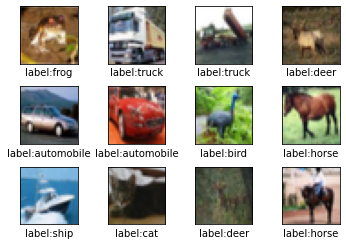

In [9]:
### draw 10 images
images = train_imgs[:12].reshape(-1, 32, 32, 3)
labels = [classes[train_labels[i]] for i in range(12)]
pp.visualize_10_images(images=images, labels= labels)

# Try from simple models to complex ones

In [10]:
input_shape = (32, 32, 3)

In [11]:
# model1: just a simple 2 blocks each with 2 conv_layers of same filter_size as follow
model1 = models.Sequential()

model1.add(layers.Conv2D(filters= 32, kernel_size= 5, padding= 'same', input_shape = (32, 32, 3)))
cfm.add_batch_norm(model1)
model1.add(layers.Conv2D(filters= 32, kernel_size= 5))
cfm.add_batch_norm(model1)
model1.add(layers.MaxPool2D(strides=2))

model1.add(layers.Conv2D(filters = 64, kernel_size = 3))
cfm.add_batch_norm(model1)
model1.add(layers.Conv2D(filters = 64, kernel_size = 3, padding= 'same'))
cfm.add_batch_norm(model1)
model1.add(layers.MaxPool2D(strides=2))

model1.add(layers.Flatten())
model1.add(layers.Dense(units= 128))
cfm.add_batch_norm(model1)
model1.add(layers.Dense(units= 10, activation= 'softmax'))

In [15]:
#my model has only 380k trainable params. which is fairly simple

In [12]:
### i want to test effect of different lr dispite of initilization
### so 'll fix inititial weights (only for the sake of experiment) in choosing lr
init_weights = model1.get_weights()

In [20]:
# my yesterday's mistake if set the lr too low 
lrs = np.linspace(start= 1e-4, stop= 0.1, num= 10)
for lr in lrs:
#     print('learning rate: %f'%(lr))
    
    # i reset weights of model 1 to init_weights after each trial of lr
    model1.set_weights(init_weights)
    
    cfm.compile_model(model= model1, lr= lr)
    his = model1.fit(x = train_imgs[:30000], y = train_labs[:30000],
                     batch_size= 256, epochs= 7, verbose = 0)
    print('\n')
    plt.plot(his.history['loss'], label = 'lr: %0.5f'%(lr))
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()

KeyboardInterrupt: 

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 144s 3ms/step - loss: 1.3246 - accuracy: 0.5289 - val_loss: 3.3007 - val_accuracy: 0.1046
Epoch 2/10
45000/45000 [==============================] - 139s 3ms/step - loss: 0.9193 - accuracy: 0.6773 - val_loss: 1.5494 - val_accuracy: 0.4282
Epoch 3/10
45000/45000 [==============================] - 134s 3ms/step - loss: 0.7343 - accuracy: 0.7454 - val_loss: 0.9276 - val_accuracy: 0.6756
Epoch 4/10
45000/45000 [==============================] - 134s 3ms/step - loss: 0.6040 - accuracy: 0.7918 - val_loss: 0.9509 - val_accuracy: 0.6790
Epoch 5/10
45000/45000 [==============================] - 142s 3ms/step - loss: 0.4998 - accuracy: 0.8303 - val_loss: 0.9305 - val_accuracy: 0.6940
Epoch 6/10
45000/45000 [==============================] - 137s 3ms/step - loss: 0.4067 - accuracy: 0.8627 - val_loss: 0.9844 - val_accuracy: 0.6826
Epoch 7/10
45000/45000 [==============================] - 144s 

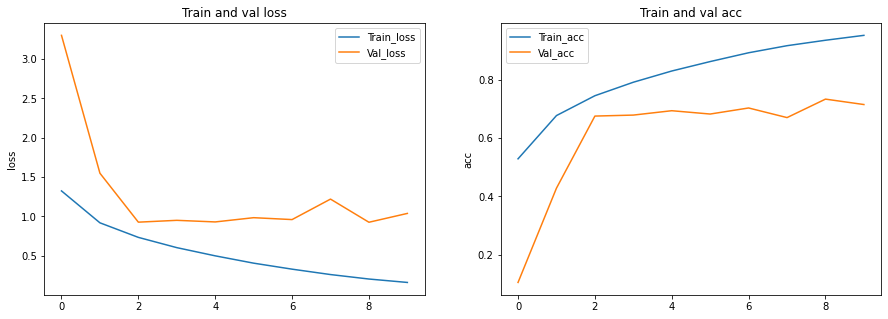

In [13]:
### i'll pick lr: 8*1e-4
### now, i'll run a few epochs to see whether my model under- or overfits my training data
model1.set_weights(init_weights)
    
cfm.compile_model(model= model1, lr= 8*1e-4)
his = model1.fit(x = train_imgs, y = train_labs, validation_split = 0.1,
                 batch_size= 256, epochs= 10, verbose = 1)

#plot loss and accuracy
pp.train_val_result(_history= his)

In [18]:
# the model clearly overfit training data.
#'i'll use dropout for dense layer to generalize better and reduce batch size to 128
model1_1 = models.Sequential()

model1_1.add(layers.SeparableConv2D(filters= 32, kernel_size= 5, padding= 'same', input_shape = (32, 32, 3)))
cfm.add_batch_norm(model1_1)

model1_1.add(layers.SeparableConv2D(filters= 32, kernel_size= 5))
cfm.add_batch_norm(model1_1)
model1_1.add(layers.MaxPool2D(strides=2))

model1_1.add(layers.SeparableConv2D(filters = 64, kernel_size = 3))
cfm.add_batch_norm(model1_1)

model1_1.add(layers.SeparableConv2D(filters = 64, kernel_size = 3, padding= 'same'))
cfm.add_batch_norm(model1_1)
model1_1.add(layers.MaxPool2D(strides=2))

model1_1.add(layers.Flatten())
model1_1.add(layers.Dense(units= 128))
cfm.add_batch_norm(model1_1)
model1_1.add(layers.Dropout(0.4))
model1_1.add(layers.Dense(units= 10, activation= 'softmax'))

In [19]:
init_weights_model1_1 = model1_1.get_weights()

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 137s 3ms/step - loss: 1.4737 - accuracy: 0.4797 - val_loss: 3.1708 - val_accuracy: 0.1364
Epoch 2/10
45000/45000 [==============================] - 138s 3ms/step - loss: 1.0444 - accuracy: 0.6310 - val_loss: 1.5607 - val_accuracy: 0.4670
Epoch 3/10
45000/45000 [==============================] - 138s 3ms/step - loss: 0.8720 - accuracy: 0.6935 - val_loss: 1.0056 - val_accuracy: 0.6524
Epoch 4/10
45000/45000 [==============================] - 141s 3ms/step - loss: 0.7617 - accuracy: 0.7313 - val_loss: 1.2843 - val_accuracy: 0.5682
Epoch 5/10
45000/45000 [==============================] - 147s 3ms/step - loss: 0.6791 - accuracy: 0.7615 - val_loss: 1.1276 - val_accuracy: 0.6320
Epoch 6/10
45000/45000 [==============================] - 150s 3ms/step - loss: 0.6076 - accuracy: 0.7875 - val_loss: 0.8171 - val_accuracy: 0.7214
Epoch 7/10
45000/45000 [==============================] - 141s 

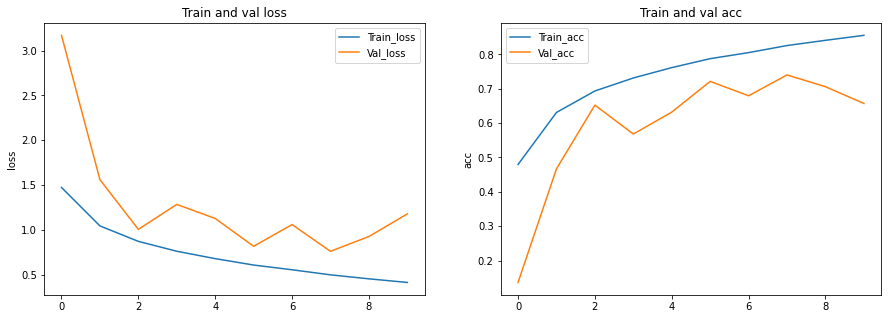

In [16]:
cfm.compile_model(model= model1_1, lr= 0.001)
his = model1_1.fit(x = train_imgs, y = train_labs, validation_split = 0.1,
                 batch_size= 256, epochs= 10, verbose = 1)

#plot loss and accuracy
pp.train_val_result(_history= his)
# why is the loss and accuracy of validation set wiggling?

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 95s 2ms/step - loss: 0.6182 - accuracy: 0.7796 - val_loss: 1.1313 - val_accuracy: 0.6360
Epoch 2/10
45000/45000 [==============================] - 84s 2ms/step - loss: 0.5770 - accuracy: 0.7962 - val_loss: 1.1394 - val_accuracy: 0.6510
Epoch 3/10
45000/45000 [==============================] - 83s 2ms/step - loss: 0.5409 - accuracy: 0.8087 - val_loss: 1.1377 - val_accuracy: 0.6512
Epoch 4/10
45000/45000 [==============================] - 83s 2ms/step - loss: 0.5171 - accuracy: 0.8151 - val_loss: 1.4148 - val_accuracy: 0.5994
Epoch 5/10
45000/45000 [==============================] - 83s 2ms/step - loss: 0.4855 - accuracy: 0.8256 - val_loss: 1.3327 - val_accuracy: 0.6226
Epoch 6/10
45000/45000 [==============================] - 82s 2ms/step - loss: 0.4595 - accuracy: 0.8366 - val_loss: 1.3179 - val_accuracy: 0.6266
Epoch 7/10
45000/45000 [==============================] - 81s 2ms/ste

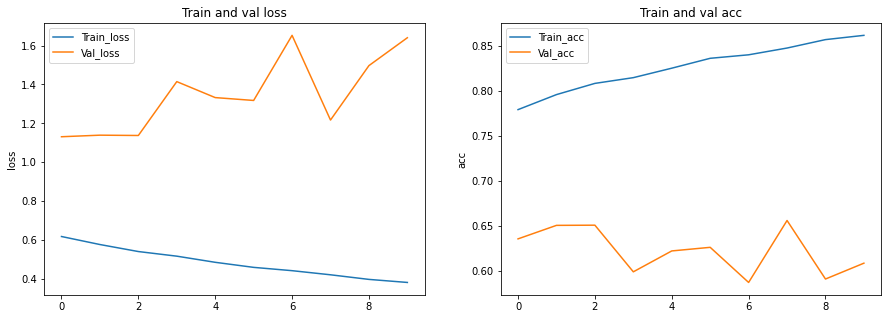

In [21]:
# model1_1.set_weights(init_weights_model1_1)
cfm.compile_model(model= model1_1, lr= 0.001)
his = model1_1.fit(x = train_imgs, y = train_labs, validation_split = 0.1,
                 batch_size= 256, epochs= 10, verbose = 1)

#plot loss and accuracy
pp.train_val_result(_history= his)
# why is the loss and accuracy of validation set wiggling?

In [43]:
### model 2: i try depth-wise seperabel conv-2D here
# i triedconv 2D but its kind of slow and doesnt seem to have any improvement over sep_conv
# Spatial dropout doesnt help( i try several dropout rates but none of them helps)

def res_block(_input, filters, kernel_size ):
    y = layers.SeparableConv2D(filters= filters, kernel_size= kernel_size, padding= 'same')(_input)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    y = layers.SeparableConv2D(filters= filters, kernel_size= kernel_size, padding= 'same')(y)
    y = layers.BatchNormalization()(y)
    _input = layers.Conv2D(filters= filters, kernel_size=1)(_input)
    y = layers.add([_input, y])
    y = layers.Activation('relu')(y)
#     y = layers.SpatialDropout2D(dropout_rate)(y)
    return y

# consider to use spatial dropout
input_data = layers.Input(shape= input_shape)

x1 = res_block(_input= input_data, filters= 64, kernel_size= 5)
x1 = layers.MaxPool2D(strides= 2)(x1)
x2 = res_block(_input= x1, filters= 64, kernel_size= 5)
x2 = layers.MaxPool2D(strides= 2)(x2)

x3 = res_block(_input= x2, filters= 128, kernel_size= 3)
x4 = res_block(_input= x3, filters= 128, kernel_size= 3)

#Dense layers (consider to replace this with global average pooling)
x4 = layers.Flatten()(x4)
x4 = layers.Dense(units= 128)(x4)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation('relu')(x4)
x4 = layers.Dropout(rate= 0.4)(x4)

output = layers.Dense(units= 10, activation= 'relu')(x4)
model2 = models.Model(inputs = input_data, outputs = output)


In [ ]:
(keras.layers.application)

In [41]:
init_weights_model2 = model2.get_weights()

In [ ]:
#lr 1: 0.005 quite slow

In [30]:
model2.set_weights(init_weights_model2)
cfm.compile_model(model= model2, lr= 0.01)
his = model2.fit(x = train_imgs, y = train_labs, validation_split = 0.1,
                 batch_size= 256, epochs= 3, verbose = 1)

#plot loss and accuracy
# pp.train_val_result(_history= his)

Train on 45000 samples, validate on 5000 samples
Epoch 1/3
45000/45000 [==============================] - 230s 5ms/step - loss: 2.1511 - accuracy: 0.3141 - val_loss: 7.0440 - val_accuracy: 0.1688
Epoch 2/3
45000/45000 [==============================] - 238s 5ms/step - loss: 1.9904 - accuracy: 0.3800 - val_loss: 3.2835 - val_accuracy: 0.2312
Epoch 3/3
45000/45000 [==============================] - 239s 5ms/step - loss: 1.8902 - accuracy: 0.4087 - val_loss: 3.5184 - val_accuracy: 0.3396


# Conclusion